In [7]:
from multi_scale_edge_detection.MultiScaleContourDetector import multi_scale_contour_detection_with_inhibition, multi_scale_contour_detection_without_inhibition
import cv2
import numpy as np

c:\Users\user1\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


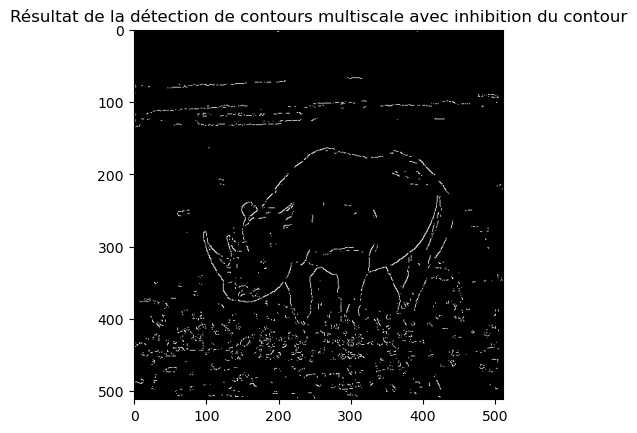

In [26]:


def preprocess_image(image_path):
    # Load the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    
    # Use Canny edge detector to find edges
    edges = multi_scale_contour_detection_with_inhibition(image, N=4, sigma=1, alpha=0.001)
    
    return edges

def assign_direction_vectors(edges):
    # Compute the gradient in the x and y direction
    grad_x = cv2.Sobel(edges, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(edges, cv2.CV_64F, 0, 1, ksize=3)
    
    # Compute the gradient magnitude and direction
    magnitude, angle = cv2.cartToPolar(grad_x, grad_y)
    


    # Create direction vectors with constant magnitude where gradient magnitude is below threshold
    direction_vectors = []

    for e , o in zip(magnitude, angle):
        angle_rad = np.radians(0)
        x_component = e * np.cos(angle_rad)
        y_component = e * np.sin(angle_rad)
        l = [x_component, y_component]
        direction_vectors.append(l)

    return np.array(direction_vectors)

# Example usage
image_path = 'database/images/rino.pgm'  # Replace with your image path
edges = preprocess_image(image_path)
direction_vectors = assign_direction_vectors(edges)




In [29]:
direction_vectors[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [10]:
import numpy as np

def cosine_similarity(vector_a, vector_b):
    """
    Calculate the cosine similarity between two vectors.
    
    Parameters:
    - vector_a: First vector (numpy array).
    - vector_b: Second vector (numpy array).
    
    Returns:
    - similarity: Cosine similarity between vector_a and vector_b.
    """
    dot_product = np.dot(vector_a, vector_b)
    norm_a = np.linalg.norm(vector_a)
    norm_b = np.linalg.norm(vector_b)
    similarity = dot_product / (norm_a * norm_b)
    return similarity

def model_image_similarity( model_directions,  image_directions):
    """
    Compute the similarity measure between a model and an image based on points and associated direction vectors.
    
    Parameters:
    - model_points: List of points (numpy arrays) representing the model.
    - model_directions: List of direction vectors (numpy arrays) for the model points.
    - image_points: List of points (numpy arrays) in the image.
    - image_directions: List of direction vectors (numpy arrays) for the image points.
    
    Returns:
    - average_similarity: The average cosine similarity between corresponding direction vectors of model and image points.
    """
    similarities = []
    for model_vector, image_vector in zip(model_directions, image_directions):
        similarity = cosine_similarity(model_vector, image_vector)
        similarities.append(similarity)
    
    average_similarity = np.mean(similarities)
    return average_similarity


In [ ]:
def template_matching(template, target):
    # Find template dimensions
    th, tw = template.shape[:2]

    # Compute the barycenter of the target image
    ty, tx = target.shape[:2]
    barycenter_x = tx // 2
    barycenter_y = ty // 2

    # Compute the size of the ROI
    roi_size_x = tw * 2
    roi_size_y = th * 2

    # Define the ROI boundaries
    roi_x = max(0, barycenter_x - roi_size_x // 2)
    roi_y = max(0, barycenter_y - roi_size_y // 2)
    roi_width = min(tx - roi_x, roi_size_x)
    roi_height = min(ty - roi_y, roi_size_y)

    # Slide template over the target image within the ROI and calculate similarity scores
    best_similarity = float('inf')
    best_location = None
    for y in range(roi_y, roi_y + roi_height - th):
        for x in range(roi_x, roi_x + roi_width - tw):
            roi = target[y:y+th, x:x+tw]
            similarity = model_image_similarity(template, roi)
            if similarity < best_similarity:
                best_similarity = similarity
                best_location = (x, y)

    return best_location


In [ ]:
if __name__ == "__main__":
    # Load images
    template_img = frame1[270:400,470:700]
    target_img = normalized_frames[10]

    # Find the best location for template matching
    best_loc = template_matching(template_img, target_img)

    # Draw rectangle around the matched region
    tw, th = template_img.shape[:2]
    cv2.rectangle(target_img, best_loc, (best_loc[0] + tw, best_loc[1] + th), (0, 255, 0), 2)

    # Display result
    cv2.imshow('Template Matching', target_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()